In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -1.636880 -0.165892 -0.092975 -0.208677  0.147700  0.195784 -0.349834   
  1  -0.880196  0.140527  0.422540 -0.541722 -0.790942  0.669348 -0.486394   
  2  -1.024426 -0.205985  0.584347  0.219072  0.959108  1.094740 -0.022727   
  3  -0.316256  0.411220  0.650641  0.492095  0.338394  0.442622  0.102169   
  4  -0.270277 -0.928218 -0.396186  0.269003 -0.760653 -1.043702 -0.773219   
  5   0.090639  0.033688  0.194421  0.635276  0.708833  0.718520  0.106909   
  6  -1.594005  0.062569  0.468813  0.748071 -0.113907  0.182798 -0.306909   
  7  -0.776616 -0.348739 -0.158624  0.275561  0.065583  1.403908  0.953999   
  8   0.650410 -0.240020  0.178175 -1.209568 -0.577639  0.314832  0.386284   
  9   0.347150 -0.485932 -0.337254 -0.066620 -0.221962 -0.748480  0.821146   
  10  0.100026  0.551516  0.446505 -0.083438  0.302998 -0.226356  0.523088   
  11 -0.610441 -0.084771 -0.505822 -0.147381  0.581429 -0.608019 -0.059106   
  12 -0.654233 -0.232958 -0.584448  0.328250  0.030346 -0.114345 -0.028546   
  13 -0.719828 -0.138428 -2.122729 -1.720010 -1.220165 -0.211961 -0.068193   
  14  0.114933 -0.276681 -0.023982 -0.033886  0.677208  0.606819  1.266415   
  15 -0.016115 -0.229863  0.346159 -0.042546  0.083003 -0.522077  0.287247   
  16 -0.630630 -0.467321 -0.361831 -0.428467 -0.247325 -0.419057 -0.531898   
  17 -1.083930 -0.518408 -0.107754 -0.539839 -1.010670 -0.555221  0.446428   
  18 -0.738782  0.104286  0.279177 -1.142242  0.322446  0.235498 -0.060198   
  19 -0.239194 -0.485256  0.015971  0.323837 -0.830317  0.414969  0.207491   
  20 -0.014977  0.656816 -0.113780 -0.103229 -0.061422  0.268285 -0.022994   
  21  0.214535  0.545929 -0.601933 -0.214786  0.522354  0.041487 -0.430997   
  22 -0.504111 -1.072738 -0.815426 -0.550259  0.742264  1.244266 -0.470540   
  23 -0.320541 -0.278504 -0.275433 -0.346465  0.064418 -0.218192  0.257746   
  24 -0.251333 -0.088209  0.017895  0.303699  0.141988  0.297259  0.719030   
1 0  -0.076915  0.707555 -0.924066 -0.816251 -0.457029 -1.004612 -0.982716   
  1   0.007413  0.215159 -0.041960 -1.360168 -0.522323  0.340828 -1.273775   
  2   0.350864  2.265527  1.150261 -0.196559 -0.013692  0.614173  0.325036   
  3   0.820447  1.360131 -0.937331 -0.558739 -0.362277 -0.434892 -0.486098   
  4   0.939501  1.247225  0.351629  0.563841 -0.678031 -0.138079  0.327791   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.691252 -0.612649  0.111997  ...  0.010505  0.023931  0.453981   
  1  -0.264957  0.458069 -0.547544  ... -0.748173 -0.120917 -1.033781   
  2   0.504957 -0.387329  0.275145  ... -0.223046  0.678553  1.056127   
  3   0.367626  0.600454  0.930055  ...  0.245689 -0.623707 -0.161012   
  4  -0.321108 -0.747737  0.668543  ... -0.398538  0.675671  0.029597   
  5   0.683485 -0.891696 -0.030193  ...  0.102018 -0.306946  0.380897   
  6  -0.326481 -0.456035  0.382998  ...  0.271679  0.656394  0.132084   
  7  -0.594692 -0.353446 -0.089373  ...  0.490106  0.023181  0.178556   
  8   0.621490 -0.045312  0.292696  ...  1.525589  0.811747  0.441596   
  9   0.346116 -0.223251  0.532177  ...  0.247613  0.615961  1.076318   
  10 -0.561616 -0.748327  0.239816  ...  0.214202  0.944816  0.688826   
  11  0.935167  0.074693  0.588226  ...  0.258024 -0.475175  0.122353   
  12 -0.680176 -0.100278  0.712571  ...  0.797437 -0.646309  1.130032   
  13 -0.612112 -0.654629  0.498102  ... -0.048214  0.196454 -0.278537   
  14  0.374630 -0.470456  0.814152  ... -0.977416 -0.285283  0.717824   
  15  0.301533 -1.314217  1.019556  ... -0.467973 -0.254899 -0.399240   
  16 -0.450328 -0.180186  1.043623  ... -0.562238 -0.211955  0.725114   
  17 -0.304702 -0.053757  0.144457  ... -0.244968  0.181511 -0.972214   
  18  0.659965 -0.159771  0.359571  ... -0.126668 -0.384145  0.177320   
  19 -0.018741  0.478576  0.165426  ... -0.068188  0.095780 -0.228399   
  20  0.095417 -0.095441  0.133216  ... -0.658526 -0.023653 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.036995  0.040987  25.300493  3.154596e-141  0.956662  1.117329


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



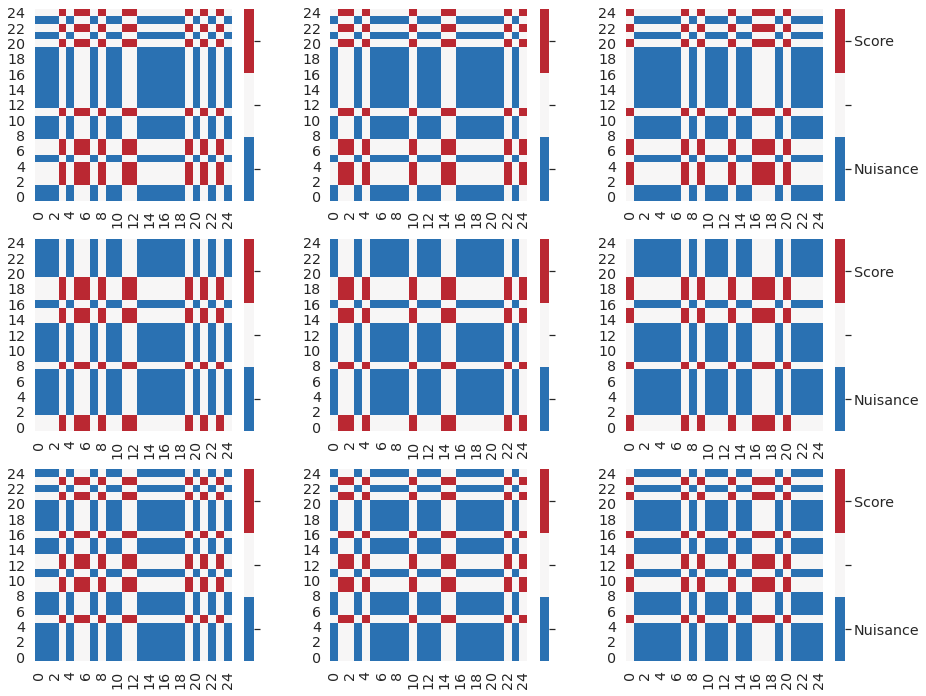

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



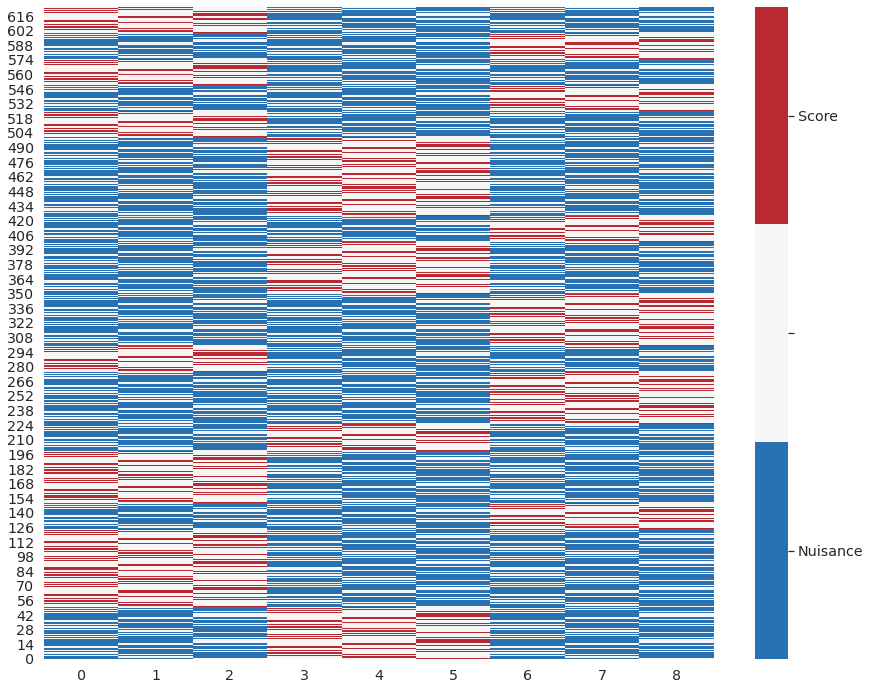

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])